## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1. Read In Data

In [6]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
# raw data head
df.head()

# after splitting head
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

First, to clean the tokens, I would convert to lowercase, remove stop words including words like "the" and "is" since those are neutral words and would not be useful in detecting phishing emails. 
Additionally, I would remove punctuation and remove special characters. 

Then, to represent the emails, I would use Term Frequency-Inverse Document Frequency to assign weights to tokens based on their frequency in an email compared to their overall occurrence across all emails. This would emphasize important words while reducing the impact of the common words that occur. 

Finally, after generating the TF-IDF matrix, PCA can be used to reduce the dimensionality, retaining only the most informative features while eliminating redundancy. The reduced feature set is then used as input for a linear model. This utilizes the flexibility linear models while efficiently handling the high dimensionality of text data.


### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

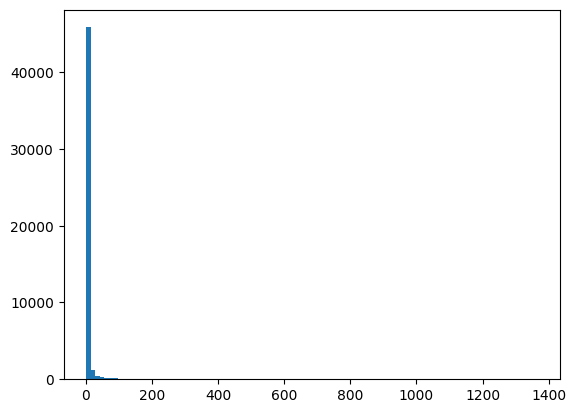

In [3]:
# histogram of occurrences of tokens

# open pickle file containing all tokens from dataset in read-binary mode
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
# count freq of each unique token in 'all_tokens' list
token_count = Counter(all_tokens)
# these r the most common tokens and their frequencies as a list of tuples
token_freq = token_count.most_common()

# df with token frequency data
gdf = pd.DataFrame(token_freq,columns=['token','count'])

# plot histogram of occurrences of tokens
gdf['count'].hist(grid=False,bins=100)

In [4]:
# describe numerical data of token frequency
gdf['count'].describe()


count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

What I noticed from this is that most tokens appear only once. The token with the highest frequency is 1365 times. The average frequency is only 5.68 times, thus most of the tokens have lower frequencies at about 10 times. 

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [8]:
df = pd.read_parquet('Phishing_clean.parquet')

# separate target variable (email type) from features
y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1. split training and test sets 
# 80% -> training, 20% -> test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

## 2. train linear regression model on training data

# fit linear regression model on training data
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)

# use trained model to make predictions on test and training data
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)

# print r-squared scores for model on the training and test data 
# shows how well model fits with the data
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )    

train:  0.6144860820476118
test:  -0.000268384328047544


In [10]:
## 3. 

# create df to store the variable names and their coefficient vals from trained model  
rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})

# stores absolute value of coefficient
rdf['abs'] = np.abs(rdf['value'])
# sort by abs col in descending order to highlight important variables
rdf.sort_values('abs',ascending=False)


,variable,value,abs
2223,1997-2002,-1.514772e+13,1.514772e+13
2224,pudge.,1.514772e+13,1.514772e+13
6,2002,1.448712e+13,1.448712e+13
96,000,-1.151892e+13,1.151892e+13
340,2005,-9.766916e+12,9.766916e+12
...,...,...,...
1052,soon,-1.974106e-04,1.974106e-04
319,thing,1.831055e-04,1.831055e-04
254,say,-1.220703e-04,1.220703e-04
512,science,-6.866455e-05,6.866455e-05


The words with the largest coefficients in absolute value that most strongly influence the predictions are: 
- 1997-2002
- pudge.
- 2002
- 000
- 2005

These are the variables with the large absolute coefficients, meaning that they have a significant influence on whether an email is detected as phishing or not. The positive or negative sign of the coefficients indicates whether the presence of these tokens increases or decreases the likelihood of an email being classified as phishing. 

In particular, 1997-2002 and 000 have negative coefficients, indicating that they may decrease the likelihood of the email being classified as phishing. However, pudge. and 2005 have large positive coefficients, indicating that they may increase the likelihood of the email being classified as phishing. 

These findings indicate some unusual and potentially noisy tokens that might not necessary be meaningful in a real-world context but strongly correlated with phishing emails in the data. Thus, it's important to investigate these tokens are valid signals or if they represent noise.

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA decomposition
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X is the one-hot-encoded token matrix

In [12]:
# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y  # Add the Email Type column for hue



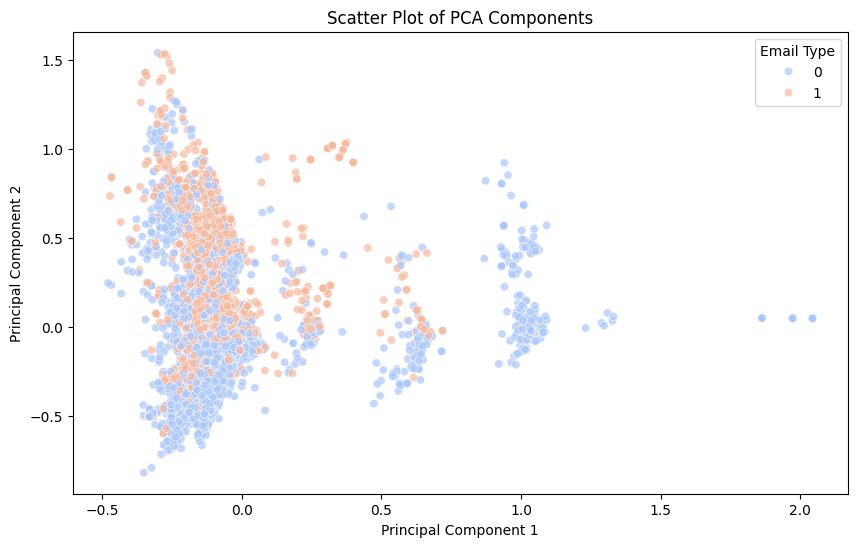

In [14]:
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', palette='coolwarm', alpha=0.7)
plt.title('Scatter Plot of PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Email Type', loc='upper right')
plt.show()


There is overlap between the two principal components, especially between -0.5 and 0.0 on the x axis. The scam points tend to have a low first component, overlapping significantly with the non-scam points. However, they also tend to have a high second component. 

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.